In [2]:
import pickle
import networkx as nx

In [ ]:
MLN = pickle.load(open('../Multilayer Network/MLN.pickle', 'rb'))

In [56]:
content_layer = pickle.load(open('../Multilayer Network/content_layer.pickle', 'rb'))

In [ ]:
# Compute PageRank
pagerank = nx.pagerank(content_layer)

In [10]:
# Compute Clustering Coefficient
import networkx as nx
import concurrent.futures

def compute_clustering(node):
    triangles = sum(1 for v in nx.all_neighbors(content_layer, node) if v in content_layer[node])
    degree = content_layer.degree(node)
    if degree < 2:
        return 0
    else:
        return 2.0 * triangles / (degree * (degree - 1))

with concurrent.futures.ThreadPoolExecutor() as executor:
    clustering = {n: executor.submit(compute_clustering, n) for n in content_layer.nodes()}
    clustering = {n: f.result() if content_layer.degree(n) >= 2 else 0 for n, f in clustering.items()}

In [12]:
pickle.dump(clustering, open('clustering.pickle', 'wb'))

In [24]:
degree_centralities = nx.degree_centrality(content_layer)
pickle.dump(degree_centralities, open('degree_centralities.pickle', 'wb'))

In [48]:
pagerank = pickle.load(open('pagerank.pickle', 'rb'))
clustering = pickle.load(open('clustering.pickle', 'rb'))
degree_centralities = pickle.load(open('degree_centralities.pickle', 'rb'))

In [49]:
def normalize_values(dictionary):
    min_value = min(dictionary.values())
    max_value = max(dictionary.values())
    for user in dictionary.keys():
        try:
            dictionary[user] = (dictionary[user] - min_value) / (max_value - min_value)
        except:
            dictionary[user] = 1
    return dictionary

pagerank = normalize_values(pagerank)
degree_centralities = normalize_values(degree_centralities)
clustering_coefficient = normalize_values(clustering)

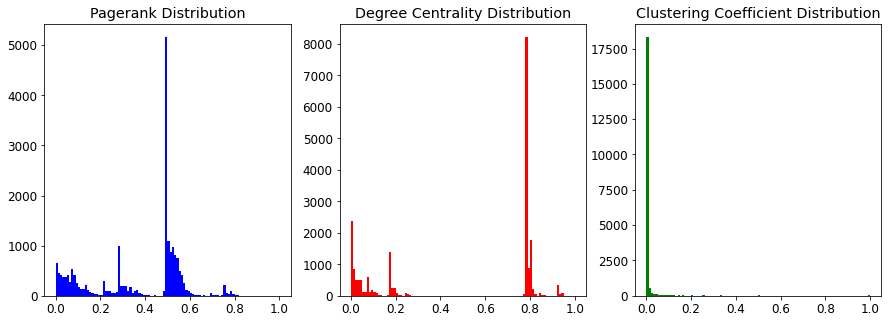

In [50]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

# Extract the values from the dictionaries
pagerank_values = list(pagerank.values())
closeness_centrality_values = list(degree_centralities.values())
clustering_coefficient_values = list(clustering_coefficient.values())

# Plot the distributions in 3 different plots in a same figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
ax1.hist(pagerank_values, bins=100, color='blue')
ax1.set_title('Pagerank Distribution')
ax2.hist(closeness_centrality_values, bins=100, color='red')
ax2.set_title('Degree Centrality Distribution')
ax3.hist(clustering_coefficient_values, bins=100, color='green')
ax3.set_title('Clustering Coefficient Distribution')
plt.savefig('PC_CC.pdf')
plt.show()

In [52]:
biggest_peak_pagerank = {}
for pg in pagerank:
    if pagerank[pg] >= 0.5 and pagerank[pg] <= 0.6:
        biggest_peak_pagerank[pg] = pagerank[pg]
print(len(biggest_peak_pagerank))

5879


In [53]:
biggest_peak_degree = {}
for dg in degree_centralities:
    if degree_centralities[dg] >= 0.78 and degree_centralities[dg] <= 0.83:
        biggest_peak_degree[dg] = degree_centralities[dg]
print(len(biggest_peak_degree))

11154


In [54]:
intersection = set(biggest_peak_pagerank.keys()).intersection(set(biggest_peak_degree.keys()))

In [57]:
labels = nx.get_edge_attributes(content_layer, 'label')
labels2 = {label: topics for label, topics in labels.items() if intersection & set(label)}

In [58]:
topics = {}
for label_topics in labels2.values():
    for topic in label_topics:
        try:
            topics[topic] += 1
        except:
            topics[topic] = 1

for t in topics:
    topics[t] = (topics[t]/len(labels2))*100

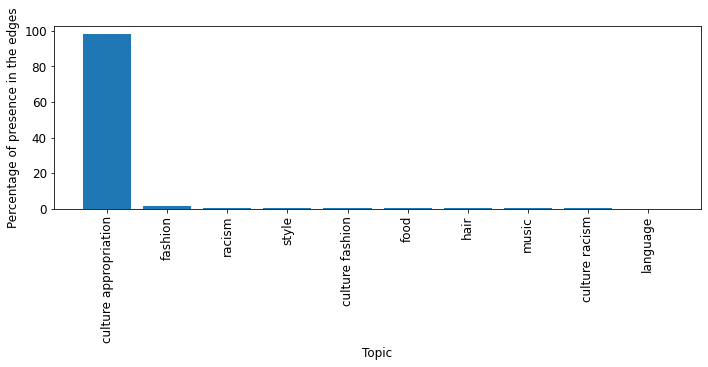

In [59]:
import matplotlib.pyplot as plt

# Order topic counts by number of occurrences
sorted_topic_counts = dict(sorted(topics.items(), key=lambda item: item[1], reverse=True))

# Plot the top 50 topics
labels = list(sorted_topic_counts.keys())[:10]
values = list(sorted_topic_counts.values())[:10]
plt.figure(figsize=(10,5))
plt.bar(labels, values)
plt.xlabel('Topic')
plt.ylabel('Percentage of presence in the edges')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('topics_key_contents.pdf')
plt.show()

In [ ]:
keytopics_net = content_layer.subgraph(list(intersection))
pickle.dump(keytopics_net, open('keytopics_net', 'wb'))

In [3]:
keytopics_net = pickle.load(open('keytopics_net', 'rb'))
user_layer = pickle.load(open('../Multilayer Network/user_layer.pickle', 'rb'))

In [6]:
MLN = pickle.load(open('../Multilayer Network/MLN.pickle', 'rb'))

In [7]:
multi_layer_edges = [(u,v,data) for u,v,data in MLN.edges(data=True) if v in keytopics_net.nodes and data['layer']=='multi_u_c']

In [8]:
len(multi_layer_edges)

6551

In [10]:
t_user_layer = nx.Graph()
for t in keytopics_net.nodes:
    t_user_layer.add_node(t)

In [17]:
user_to_t_map = {}
for edge in multi_layer_edges:
    if edge[0] not in user_to_t_map:
        user_to_t_map[edge[0]] = []
    user_to_t_map[edge[0]].append(edge[1])
user_to_t_map_filtered = {}
for c in user_to_t_map:
    if len(user_to_t_map[c]) > 1:
        user_to_t_map_filtered[c] = user_to_t_map[c]

In [31]:
key_users = pickle.load(open('key_users.pickle', 'rb'))
len(set(user_to_t_map.keys()).intersection(set(key_users)))

1475

In [20]:
import pandas as pd
comments = pd.read_csv('../Dataset/comments_2022.csv', header=0)
comments.head()

,id,parent_id,author,subreddit,body
0,hqqvfvb,t1_hqqt3r3,BasicComplexities,VaushV,"\n&gt;. You use French people flippantly, but ..."
1,hqqxbu8,t1_hqqhgr2,RagingAardvark,daddit,Thank you! I was actually recently mulling ove...
2,hqqz28x,t3_rsooda,malarky-b,asianamerican,Maybe I'm just tired but I don't get the comme...
3,hqr027z,t1_hqqz64g,AdventurousAnxiety78,Afghan,"No, the coins are one of many diverse versions..."
4,hqr0j0w,t3_rt7dak,stjeana,TooAfraidToAsk,Cultural appropriation is vs and doesnt have a...


In [26]:
comments[comments['id'] == 'hqqz28x']['subreddit'].item()

'asianamerican'

In [28]:
result = {}
for user_node, content_nodes in user_to_t_map_filtered.items():
    subs = []
    for c in content_nodes:
        subs.append(comments[comments['id'] == c]['subreddit'].item())
    subs = list(set(subs))
    for i, c1 in enumerate(content_nodes):
        for c2 in content_nodes[i+1:]:
            try:
                result[(c1,c2)].extend(subs)
                result[(c1,c2)] = list(set(result[(c1,c2)]))
            except:
                result[(c1,c2)] = subs

In [32]:
for res in result.keys():
    t_user_layer.add_edge(res[0], res[1], label=result[res])
pickle.dump(t_user_layer, open('t_user_layer.pickle', 'wb'))

In [35]:
print(len(t_user_layer.nodes))
print(len(t_user_layer.edges))
print(nx.number_of_isolates(t_user_layer))
print(nx.density(t_user_layer))

5838
1025
4603
6.01589263844315e-05


In [38]:
community_counts = {}
for key, value  in result.items():
    for sub in value:
        try:
            community_counts[sub] += 1
        except:
            community_counts[sub] = 1

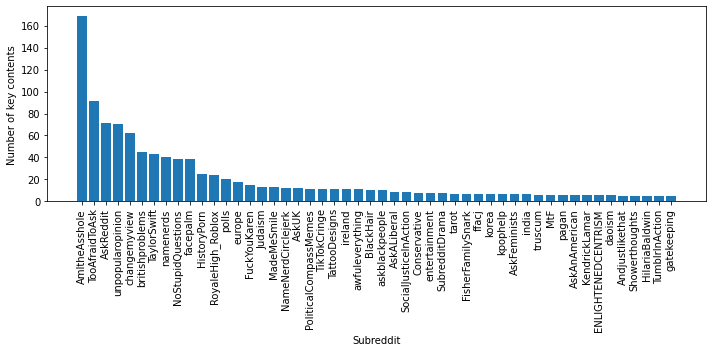

In [45]:
import matplotlib.pyplot as plt
from collections import defaultdict

# Order topic counts by number of occurrences
sorted_community_counts = dict(sorted(community_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the top 50 topics
plt.figure(figsize=(10,5))
labels = list(sorted_community_counts.keys())[:50]
values = list(sorted_community_counts.values())[:50]
plt.bar(labels, values)
plt.xlabel('Subreddit')
plt.ylabel('Number of key contents')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('key_contents_subs.pdf')
plt.show()

In [47]:
key_users_comments = comments.loc[comments['author'].isin(key_users)]
len(key_users_comments.loc[(key_users_comments['subreddit']=='AmItheAsshole') & ()]

2237